# Data Science Using Python
### Assignment 2: Text Classification
#### By Ramanathan Moorthy (18201670) and Anjali Tiwari (18202322)

In [103]:
import bs4
import urllib.request
import pandas as pd
import re
import nltk
import matplotlib
import sklearn.model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ramanathan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ramanathan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ramanathan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
home = 'http://mlg.ucd.ie/modules/yalp'
hm_link = 'http://mlg.ucd.ie/modules/yalp/health_medical_list.html' #Health & Medical Reviews
aut_link = 'http://mlg.ucd.ie/modules/yalp/automotive_list.html'#Automotive Reviews

In [106]:
def read_bsns(link):    # Function to read link values for all the Bussiness inside a Catregory
    response = urllib.request.urlopen(link)
    html = response.read().decode()
    #print(html)
    soup = bs4.BeautifulSoup(html,"html.parser")
    #print(parser.prettify())

    bsns_list = list()
    for link in soup.find_all('a'):
        text = link.get('href')
        bsns_list.append(text)

    print(len(bsns_list),'business links have been read from', soup.find('h3','info').get_text())
    return bsns_list

In [6]:
def read_review(bsns_list):     #Function to read review text and rating stars and store it as CSV
    dataset = {}
    dataset['rvw_label'] = list()
    dataset['rvw_text'] = list()
    for est in bsns_list:
        response = urllib.request.urlopen(home+"/"+est)
        html1 = response.read().decode()
        soup = bs4.BeautifulSoup(html1,"html.parser")
        #print(soup.prettify())

        for review in soup.find_all('div','review'):
            try:
                # Store '1' if reviews are Positive(5&4 stars) and '0' for Negative(3,2&1 Stars)
                star_text = review.find('img').get('alt')
                if star_text in ['1-star', '2-star', '3-star']:
                    dataset['rvw_label'].append(0)
                elif star_text in ['5-star', '4-star']:
                    dataset['rvw_label'].append(1)
                else:
                    print('Flag', review)
                dataset['rvw_text'].append(review.find('p', 'text').get_text())
            except:
                print('Error!! in storing review by', review.find('i').get_text(), "on", soup.find('h3', 'info').get_text() )
                
    print(len(dataset['rvw_text']), "reviews have been read")                
    return dataset

## Task 1: Scraping reviews and storing along with binary class labels

### Categories selected: Health and Medical, Automotive Reviews

In [8]:
hm_list = read_bsns(hm_link)
aut_list = read_bsns(aut_link)

hm_dataset = read_review(hm_list)
aut_dataset = read_review(aut_list)

hm_dataframe = pd.DataFrame(hm_dataset)
aut_dataframe = pd.DataFrame(aut_dataset)

print("Storing reviews into CSV files: H&M.csv, Aut.csv")
hm_dataframe.to_csv('H&M.csv')
aut_dataframe.to_csv('Aut.csv')

122 business links have been read from Yalp — Fresh Reviews for Health and medical
101 business links have been read from Yalp — Fresh Reviews for Automotive
1450 reviews have been read
1455 reviews have been read
Storing reviews into CSV files: H&M.csv, Aut.csv


In [9]:
aut_dataframe.head()

,rvw_label,rvw_text
0,1,I arrived at 3 PM and the dealership closed at...
1,0,I dropped my car off on a Wednesday morning fo...
2,1,My parents have been buying cars off of Donna ...
3,1,I recently bought another car from Donna Dunni...
4,1,I had to schedule an appointment due to the ai...


## Task 2: PreProcessing and Classification Model

In [107]:
#Without any preprocessing
vectorizer = CountVectorizer(ngram_range = (1,2))
X_samp = vectorizer.fit_transform(hm_dataset['rvw_text'])
X_samp.shape   #Not used anywhere in the notebook. For the purpose of displaying Vector dimension without any preprocessing

(1450, 81915)

In [11]:
# define the function with NLTK Porter Stemming
def stem_tokenizer(text):
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # then use NLTK to perform stemming on each token
    stemmer = PorterStemmer()
    stems = []
    for token in tokens:
        stems.append( stemmer.stem(token) )
    return stems

In [28]:
StopWord = stopwords.words('english')
print(len(StopWord), "stop words from NLTK corpus")
#Updating Stopword collection to accomodate stemmed stop words. The words are taken from the warning showed during CountVectorization
for i in ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv','anywh', 'becau', 'doe', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'somewh']:
    StopWord.append(i)
print(len(StopWord), "stop words after addition of stemmed stop words")

179 stop words from NLTK corpus
270 stop words after addition of stemmed stop words


### Vectorising algorithm and vectorising

In [110]:
def vect(text_list):
    for i in range(len(text_list)):
        text_list[i] = text_list[i].lower()
        text_list[i] = re.sub(r'[0-9]+', '', text_list[i]) #To remove numbers(Year, Time, Fee) from the reviews
        
    #Count Vectorizer with Unigram and Bigram tokenzation. Stem Tokenization using PorterStemming
    #Ignore terms that have a document frequency strictly lower than 3 (min_df = 3)
    vectorizer = CountVectorizer(ngram_range = (1,2),stop_words = StopWord ,min_df = 5,tokenizer=stem_tokenizer)
    X = vectorizer.fit_transform(text_list)
    print(X.shape)
    #term = vectorizer.get_feature_names()
    #print(term)
    return X

In [111]:
complete_dataset = hm_dataset['rvw_text']+aut_dataset['rvw_text']
#print(len(complete_dataset)) #2905
#print(complete_dataset[1450]) #First review of Automotive. Reviews are in Order

#Vectorising the complete dataset with Reviews from two categories
#X_full[0:1450] =  Health and Medicine review vectors
#X_full[1450:2905] = Automotive review vectors
X_full = vect(complete_dataset)
X_full.shape # Reviews are merged to anable cross model validation

(2905, 5376)


(2905, 5376)

### Splitting Test and Train data for both categories with 75:25 (Train:Test) proportion

hm - Health and Medicine

aut - Automotive

In [112]:
hm_train, hm_test, hm_rslt_train, hm_rslt_test = train_test_split(X_full[0:1450], hm_dataset['rvw_label'])
print("Shape of Health and Medicine Train vectors",hm_train.shape)
print("Shape of Health and Medicne Test Vectors", hm_test.shape)

Shape of Health and Medicine Train vectors (1087, 5376)
Shape of Health and Medicne Test Vectors (363, 5376)


In [113]:
aut_train, aut_test, aut_rslt_train, aut_rslt_test = train_test_split(X_full[1450:2905], aut_dataset['rvw_label'])
print("Shape of Automotive Train vectors",aut_train.shape)
print("Shape of Automotive Test Vectors", aut_test.shape)

Shape of Automotive Train vectors (1091, 5376)
Shape of Automotive Test Vectors (364, 5376)


### KNearestNeighbour Classification model

In [95]:
def KNN_model(vectors, result, N): #N - number of Neighbours
    model = KNeighborsClassifier(n_neighbors=N)
    # build a model on the document-term matrix created from the original set of documents
    model.fit(vectors, result)
    #print(model)
    return(model)

In [114]:
print('KNN Model on Health and Medicine Reviews')
hm_model = KNN_model(hm_train, hm_rslt_train, 3)
print('\nModel Trained on Train dataset with N=3')
predicted = hm_model.predict(hm_test)
print('Results predicted for Test dataset')
acc = accuracy_score(hm_rslt_test, predicted)
print("\n   KNN Classification accuracy score = %.2f" % acc)


KNN Model on Health and Medicine Reviews

Model Trained on Train dataset with N=3
Results predicted for Test dataset

   KNN Classification accuracy score = 0.82


In [115]:
print('KNN Model on Automotive Reviews')
aut_model = KNN_model(aut_train, aut_rslt_train, 3)
print('\nModel Trained on Train dataset with N=3')
predicted = aut_model.predict(aut_test)
print('Results predicted for Test dataset')
acc = accuracy_score(aut_rslt_test, predicted)
print("\n   KNN accuracy score = %.2f" % acc)

KNN Model on Automotive Reviews

Model Trained on Train dataset with N=3
Results predicted for Test dataset

   KNN accuracy score = 0.69


### Naive Bayes Classification Model

In [70]:
def NB_Model(vectors, result):
    model = MultinomialNB()
    model.fit(vectors, result)
    return model

In [116]:
print("Naive Bayes Classifier on Health and Medicine review")
hm_NB_model = NB_Model(hm_train, hm_rslt_train)
print('\nModel Trained on Train dataset with NB Classifier')
predicted = hm_NB_model.predict(hm_test)
print('Results predicted for Test dataset')
acc = accuracy_score(hm_rslt_test, predicted)
print("\n   Naive Bayes Classification accuracy score = %.2f" % acc)

Naive Bayes Classifier on Health and Medicine review

Model Trained on Train dataset with NB Classifier
Results predicted for Test dataset

   Naive Bayes Classification accuracy score = 0.93


In [117]:
print("Naive Bayes Classifier on Automotive review")
aut_NB_model = NB_Model(aut_train, aut_rslt_train)
print('\nModel Trained on Train dataset with NB Classifier')
predicted = aut_NB_model.predict(aut_test)
print('Results predicted for Test dataset')
acc = accuracy_score(aut_rslt_test, predicted)
print("\n   Naive Bayes Classification accuracy score = %.2f" % acc)

Naive Bayes Classifier on Automotive review

Model Trained on Train dataset with NB Classifier
Results predicted for Test dataset

   Naive Bayes Classification accuracy score = 0.92


#### Results for Classification Model Cross validation

**Naive Bayes** classifier model performs with great accuracy on both the categories we have selected(Automotive || Health and Medicine). It has greater than 90% accuracy for Test Dataset predictions. 

**KNearestNeighborhood** classification model performs relatively poor compared to NB model with accuracy of 73% for both categories

### Experiment with KNN 
#### Effect of Neighbourhood Size on Predictions

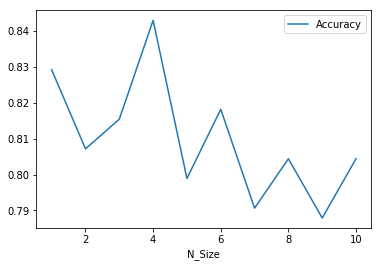

In [118]:
res_dict = {}
res_dict['N_Size'] = list()
res_dict['Accuracy'] = list()
for N in range(1,11):
    hm_model = KNN_model(hm_train, hm_rslt_train, N)
    predicted = hm_model.predict(hm_test)
    acc = accuracy_score(hm_rslt_test, predicted)
    res_dict['N_Size'].append(N)
    res_dict['Accuracy'].append(acc)
#print(res_dict)
df = pd.DataFrame(res_dict)
df.set_index('N_Size').plot()

**Results:**
The prediction results for gradually increasing Nieghborhood Size(N) are shown in above graph. The predictions accuracy gradually decreases as we increase the Neighbourhood size. This is due to the higher chance of inclusion of the bad neighbours(belong to different Class(say, Negative) rather than the actual class(say, Positive)) into the NeighbourHood. There is a peculiar Behaviour of showing comparitively high values for Even N value(N = 2,4,6) compared to adjoining odd N value. 

# Task 3: Cross Model Performance

We are using Naive Bayes Classifier model to validate the predictions between the categories. Naive Bayes classifier model has shown High accuracy in predicting Health and Medical Reviews(93%) and Automotive Reviews(94%), when it has been trained and tested within the same category.

In [119]:
#hm_NB_model which has already been trained with Health and Review Train(75%) data

predicted = hm_NB_model.predict(aut_test) # Predicting results for Automotive Test Dataset
print('Results predicted for Automotive Test dataset on Health and Medine(H&M) Naive Bayes Model')
acc = accuracy_score(aut_rslt_test, predicted)
print("\n   Naive Bayes Classification accuracy score = %.2f" % acc)
print("\nClassification report", metrics.classification_report(aut_rslt_test, predicted))

Results predicted for Automotive Test dataset on Health and Medine(H&M) Naive Bayes Model

   Naive Bayes Classification accuracy score = 0.75

Classification report               precision    recall  f1-score   support

           0       0.59      0.95      0.73       130
           1       0.96      0.63      0.76       234

   micro avg       0.75      0.75      0.75       364
   macro avg       0.78      0.79      0.75       364
weighted avg       0.83      0.75      0.75       364



In [120]:
#aut_NB_model which has already been trained with Automotive Train(75%) data

predicted = aut_NB_model.predict(hm_test) # Predicting results for Automotive Test Dataset
print('Results predicted for Health and Medine(H&M) Test dataset on Automotive Naive Bayes Model')
acc = accuracy_score(hm_rslt_test, predicted)
print("\n   Naive Bayes Classification accuracy score = %.2f" % acc)
print("\nClassification report", metrics.classification_report(hm_rslt_test, predicted))

Results predicted for Health and Medine(H&M) Test dataset on Automotive Naive Bayes Model

   Naive Bayes Classification accuracy score = 0.90

Classification report               precision    recall  f1-score   support

           0       0.75      0.88      0.81        90
           1       0.96      0.90      0.93       273

   micro avg       0.90      0.90      0.90       363
   macro avg       0.85      0.89      0.87       363
weighted avg       0.91      0.90      0.90       363



#### Conclusion:

From the results, we see a clear reduction in classifier accuracy when we predict results for test dataset across categories. We were expecting even greater reduction in prediction accuracy since the two selected categories( Automotive, and Health and Medical) are of completely different domain but still the model has performed admirably well in predicting Test datasets across categories. The Health & Model has 80% accuracy for Automotive review data and Automotive NB Model has 88% accuracy for H&M data. This could be due to robust review tokenization and presence of common sentiment(positive or negative) words in complete set of reviews across categories.